# Interactive Positional Encoding Demo

**Author:** Varun Reddy

Welcome to my interactive demonstration notebook! I created this to showcase the core components of my positional encoding implementation and visualize how they work in practice.

In this notebook, I will:
1. **Visualize** the learned positional embeddings
2. **Demonstrate** the attention mechanism
3. **Compare** different encoding strategies on a small sample


In [1]:
import sys
import os
from pathlib import Path

# Robustly find project root
current_path = Path(os.getcwd())
if current_path.name == 'notebooks':
    project_root = current_path.parent
else:
    project_root = current_path

# Add src to sys.path
src_path = project_root / 'src'
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))
    print(f"✅ Added {src_path} to python path")

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import custom modules
try:
    from positional_encodings import (
        LearnedAbsolutePositionalEncoding,
        LearnedRelativePositionalBias,
        ContinuousPositionalEncoding,
        SinusoidalPositionalEncoding
    )
    from train import Trainer
    from model import create_model
    from dataset import create_dataloaders
    print("✅ All modules imported successfully!")
except ImportError as e:
    print(f"❌ Import failed: {e}")
    print("Please ensure running from correct kernel and 'src' directory exists.")

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

✅ Added c:\Users\varun\Downloads\ml-positional-encoding\src to python path
✅ All modules imported successfully!


## 1. Visualizing Positional Encodings

First, let's look at what the learned embeddings actually look like. I'll instantiate each method and plot their output for a short sequence.

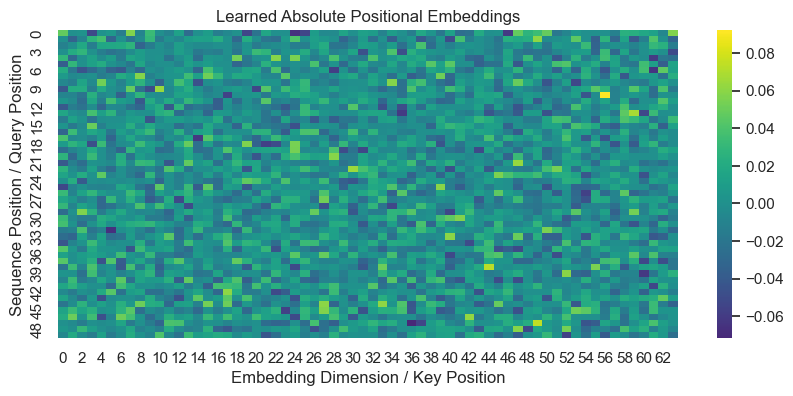

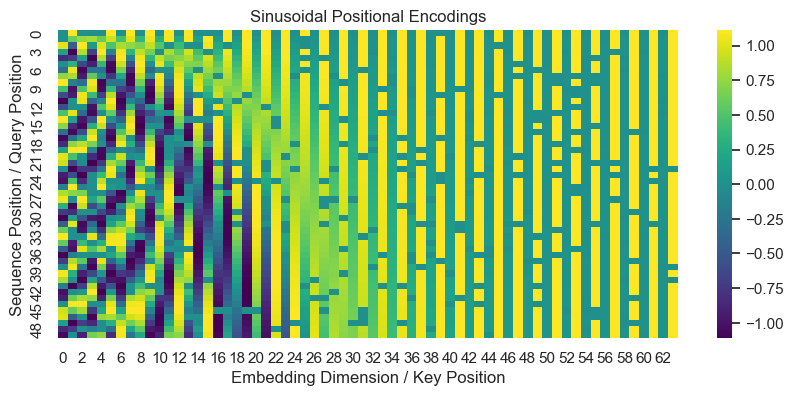

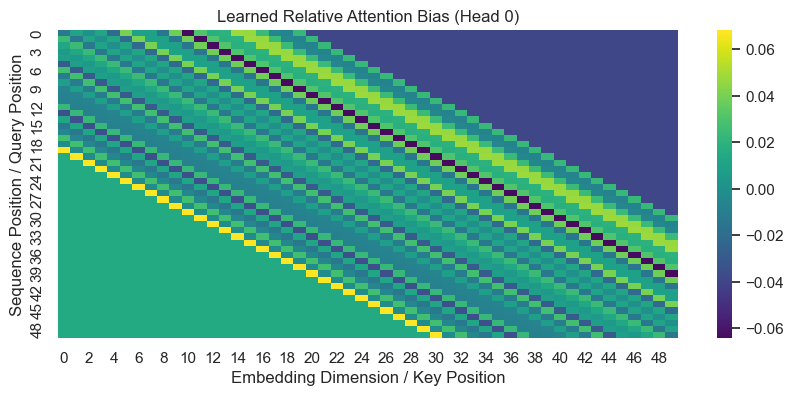

In [2]:
def plot_positional_encoding(encoding_layer, title, max_len=50, d_model=64):
    plt.figure(figsize=(10, 4))
    
    # Create input sequence
    x = torch.zeros(1, max_len, d_model)
    
    # Get encoding
    with torch.no_grad():
        if isinstance(encoding_layer, LearnedRelativePositionalBias):
            # Relative bias returns (num_heads, seq_len, seq_len)
            # We want to visualize one head, hence [0]
            pe = encoding_layer(max_len)[0] 
        else:
            # Absolute/Continuous returns (1, seq_len, d_model)
            # We remove batch dimension [0]
            pe = encoding_layer(x)[0]
            
    # Plot
    sns.heatmap(pe.numpy(), cmap='viridis', center=0)
    plt.title(title)
    plt.xlabel('Embedding Dimension / Key Position')
    plt.ylabel('Sequence Position / Query Position')
    plt.show()

# 1. Learned Absolute
abs_enc = LearnedAbsolutePositionalEncoding(d_model=64, max_len=50)
plot_positional_encoding(abs_enc, "Learned Absolute Positional Embeddings")

# 2. Sinusoidal (Baseline)
sin_enc = SinusoidalPositionalEncoding(d_model=64, max_len=50)
plot_positional_encoding(sin_enc, "Sinusoidal Positional Encodings")

# 3. Learned Relative Bias
rel_enc = LearnedRelativePositionalBias(num_heads=8, max_distance=20)
plot_positional_encoding(rel_enc, "Learned Relative Attention Bias (Head 0)")

## 2. Model Training Demo

Now I'll run a quick training loop right here in the notebook to show convergence on the pattern task.

Generating dataset...
Created 1000 training samples.
Starting quick training...


c:\Users\varun\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


Epoch 1: Loss = 1.1942
Epoch 2: Loss = 0.1879
Epoch 3: Loss = 0.0070
Epoch 4: Loss = 0.0021
Epoch 5: Loss = 0.0014


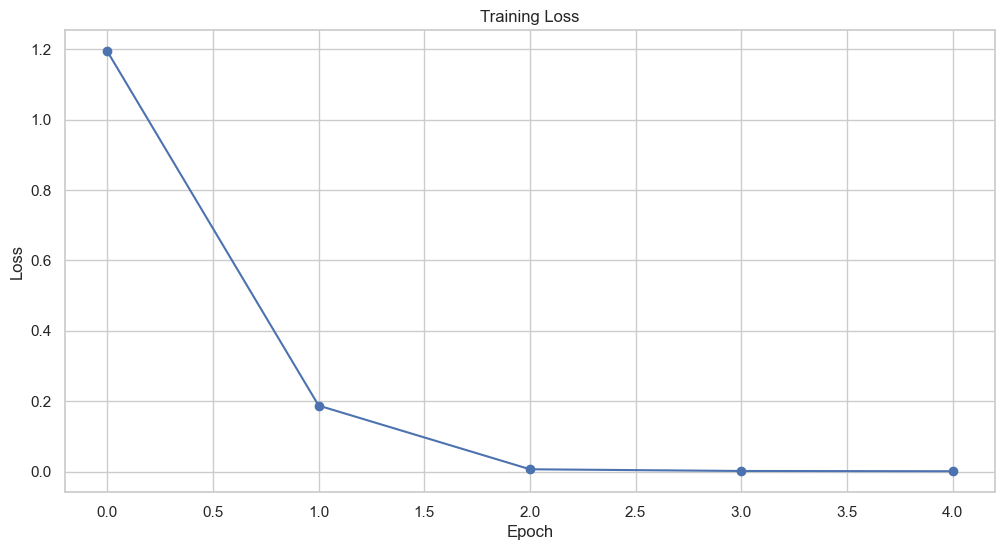

In [3]:
# Setup
BATCH_SIZE = 32
SEQ_LEN = 32
D_MODEL = 64

print("Generating dataset...")
train_loader, val_loader, info = create_dataloaders(
    dataset_type='pattern', 
    train_samples=1000, 
    val_samples=200,
    batch_size=BATCH_SIZE,
    seq_len=SEQ_LEN
)

print(f"Created {len(train_loader.dataset)} training samples.")

# Create Model
model = create_model(
    vocab_size=20, 
    num_classes=3, 
    pos_encoding_type='learned_absolute',
    d_model=D_MODEL,
    num_heads=4,
    num_layers=2
)

# Quick Training Loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

losses = []
model.train()

print("Starting quick training...")
for epoch in range(5):
    epoch_loss = 0
    for batch in train_loader:
        x, y = batch
        optimizer.zero_grad()
        # Model returns (logits, attn_weights) - we only need logits here
        logits, _ = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")

plt.plot(losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## 3. Attention Visualization

Finally, let's visualize where the model applies attention for a specific input pattern.

Input sequence: [7, 4, 10, 8, 17, 19, 16, 19, 3, 4, 18, 13, 6, 14, 1, 7, 18, 5, 0, 2, 4, 19, 7, 16, 1, 18, 9, 16, 12, 7, 11, 13]
Predicted class: 2
True class: 2


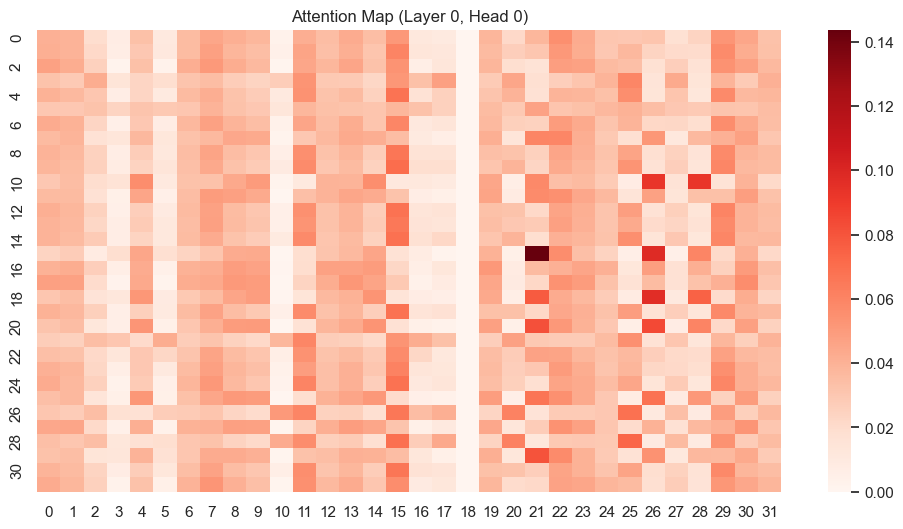

In [4]:
model.eval()
x_sample, y_sample = next(iter(val_loader))
x_sample = x_sample[:1]

# Get attention weights
with torch.no_grad():
    logits, attn = model(x_sample, return_attention=True)

print(f"Input sequence: {x_sample[0].tolist()}")
print(f"Predicted class: {logits.argmax(dim=1).item()}")
print(f"True class: {y_sample[0].item()}")

if attn is not None:
    # Initial layer, Head 0
    sns.heatmap(attn[0, 0].numpy(), cmap='Reds')
    plt.title("Attention Map (Layer 0, Head 0)")
    plt.show()
else:
    print("Model doesn't support attention return.")